# Item-based collaborative filtering

We will use the characteristics of the movie, such as style, plot, director and main actors, etc., to calculate the cosine similarity between different movies. 

We use the first 250 English movies of IMDB downloaded from data.world as our data set

In [1]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install rake_nltk
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in e:\anaconda3\envs\665final\lib\site-packages (0.24.1)


## Step 1: import Python libraries and dataset
Ensure that the Rapid Automatic Keyword Extraction (RAKE) library has been installed (or pip install rake_nltk). Refer to https://pypi.org/project/rake-nltk/ for more information.

In [2]:
from rake_nltk import Rake   # ensure this is installed

import nltk
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('IMDB_Top250Engmovies2_OMDB_Detailed.csv')   # same data 250 rows × 38 columns
df2 = pd.read_csv('IMDB_Top250Engmovies2_OMDB_Detailed.csv')
df

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
0,1,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/shawshank_rede...,27 Jan 1998,NaN,Columbia Pictures,NaN,True
1,2,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay), Francis Ford Coppola ...","Marlon Brando, Al Pacino, James Caan, Richard ...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather/,09 Oct 2001,NaN,Paramount Pictures,http://www.thegodfather.com,True
2,3,The Godfather: Part II,1974,R,20 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay), Mario Puzo ...","Al Pacino, Robert Duvall, Diane Keaton, Robert...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather_part...,24 May 2005,NaN,Paramount Pictures,http://www.thegodfather.com/,True
3,4,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","Christian Bale, Heath Ledger, Aaron Eckhart, M...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/the_dark_knight/,09 Dec 2008,"$533,316,061",Warner Bros. Pictures/Legendary,http://thedarkknight.warnerbros.com/,True
4,5,12 Angry Men,1957,APPROVED,01 Apr 1957,96 min,"Crime, Drama",Sidney Lumet,"Reginald Rose (story), Reginald Rose (screenplay)","Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/1000013-12_ang...,06 Mar 2001,NaN,Criterion Collection,http://www.criterion.com/films/27871-12-angry-men,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,The Lost Weekend,1945,NOT RATED,01 Jan 1946,101 min,"Drama, Film-Noir",Billy Wilder,"Charles R. Jackson (from the novel by), Charle...","Ray Milland, Jane Wyman, Phillip Terry, Howard...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/lost_weekend/,06 Feb 2001,NaN,Paramount Pictures,NaN,True
246,247,Short Term 12,2013,R,23 Aug 2013,96 min,Drama,Destin Daniel Cretton,Destin Daniel Cretton,"Brie Larson, John Gallagher Jr., Stephanie Bea...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/short_term_12_...,14 Jan 2014,NaN,Cinedigm,http://shortterm12.com,True
247,248,His Girl Friday,1940,APPROVED,18 Jan 1940,92 min,"Comedy, Drama, Romance",Howard Hawks,"Charles Lederer (screen play), Ben Hecht (from...","Cary Grant, Rosalind Russell, Ralph Bellamy, G...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/his_girl_friday/,28 Dec 2004,NaN,Columbia Pictures,NaN,True
248,249,The Straight Story,1999,G,03 Nov 1999,112 min,"Biography, Drama",David Lynch,"John Roach, Mary Sweeney","Sissy Spacek, Jane Galloway Heitz, Joseph A. C...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/straight_story/,07 Nov 2000,NaN,Buena Vista Pictures,http://disney.go.com/DisneyPictures/straightst...,True


In [4]:
# data overview
print('Rows x Columns : ', df.shape[0], 'x', df.shape[1])
print('Features: ', df.columns.tolist())
print('\nUnique values:')
print(df.nunique())
for col in df.columns:
    print(col, end=': ')
    print(df[col].unique())

Rows x Columns :  250 x 38
Features:  ['Unnamed: 0', 'Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster', 'Ratings.Source', 'Ratings.Value', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type', 'tomatoMeter', 'tomatoImage', 'tomatoRating', 'tomatoReviews', 'tomatoFresh', 'tomatoRotten', 'tomatoConsensus', 'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 'tomatoURL', 'DVD', 'BoxOffice', 'Production', 'Website', 'Response']

Unique values:
Unnamed: 0           250
Title                250
Year                  85
Rated                 10
Released             244
Runtime              103
Genre                110
Director             155
Writer               238
Actors               248
Plot                 250
Language              68
Country               39
Awards               235
Poster               250
Ratings.Source         1
Ratings.Value         13
Metascore             44
imdb

In [5]:
# type of entries, how many missing values/null fields
df.info()
print('\nMissing values:  ', df.isnull().sum().values.sum())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         250 non-null    int64  
 1   Title              250 non-null    object 
 2   Year               250 non-null    int64  
 3   Rated              250 non-null    object 
 4   Released           248 non-null    object 
 5   Runtime            250 non-null    object 
 6   Genre              250 non-null    object 
 7   Director           250 non-null    object 
 8   Writer             249 non-null    object 
 9   Actors             250 non-null    object 
 10  Plot               250 non-null    object 
 11  Language           250 non-null    object 
 12  Country            250 non-null    object 
 13  Awards             245 non-null    object 
 14  Poster             250 non-null    object 
 15  Ratings.Source     250 non-null    object 
 16  Ratings.Value      250 non

Unnamed: 0             0
Title                  0
Year                   0
Rated                  0
Released               2
Runtime                0
Genre                  0
Director               0
Writer                 1
Actors                 0
Plot                   0
Language               0
Country                0
Awards                 5
Poster                 0
Ratings.Source         0
Ratings.Value          0
Metascore             73
imdbRating             0
imdbVotes              0
imdbID                 0
Type                   0
tomatoMeter          250
tomatoImage          250
tomatoRating         250
tomatoReviews        250
tomatoFresh          250
tomatoRotten         250
tomatoConsensus      250
tomatoUserMeter      250
tomatoUserRating     250
tomatoUserReviews    250
tomatoURL              0
DVD                    3
BoxOffice            175
Production             0
Website              119
Response               0
dtype: int64

In [6]:
# summary statistics for all numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,250.0,125.500000,72.312977,1.0,63.25,125.5,187.750,250.0
Year,250.0,1982.676000,24.809212,1921.0,1961.25,1988.0,2003.000,2017.0
Metascore,177.0,80.045198,11.030340,53.0,72.00,81.0,89.000,100.0
imdbRating,250.0,8.244000,0.245735,8.0,8.10,8.2,8.375,9.3
tomatoMeter,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tomatoImage,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tomatoRating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tomatoReviews,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tomatoFresh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tomatoRotten,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
import matplotlib.pyplot as plt

col_name = df.columns.tolist()
print(col_name)
df.imdbRating.dtypes

['Unnamed: 0', 'Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster', 'Ratings.Source', 'Ratings.Value', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type', 'tomatoMeter', 'tomatoImage', 'tomatoRating', 'tomatoReviews', 'tomatoFresh', 'tomatoRotten', 'tomatoConsensus', 'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 'tomatoURL', 'DVD', 'BoxOffice', 'Production', 'Website', 'Response']


dtype('float64')

In [8]:
#df.imdbVotes.dtypes
tempDf = df
tempDf = tempDf[tempDf['imdbRating']>8.5]

tempDf2 = df2
tempDf2 = tempDf2[tempDf2['imdbRating']>8.5]

imdbRating
8.6    8
8.7    5
8.8    5
8.9    4
9.0    2
9.2    1
9.3    1
Name: imdbVotes, dtype: int64


<AxesSubplot:xlabel='imdbRating'>

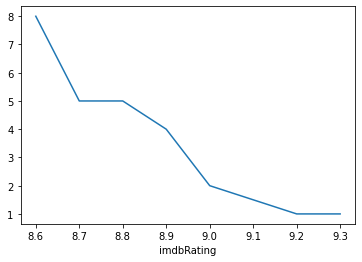

In [9]:
df_gross = tempDf.groupby(['imdbRating'])['imdbVotes'].count()
print(df_gross)
df_gross.plot()

In [10]:
ratingList = tempDf.imdbRating.tolist()
imdbVotesList = tempDf.imdbVotes.tolist()

def pare_to_frontier(Xs, Ys, maxX = True, maxY = True):
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
    p_front = [myList[0]]    
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: 
                p_front.append(pair) 
        else:
            if pair[1] <= p_front[-1][1]: 
                p_front.append(pair) 
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

p_front = pare_to_frontier(ratingList, imdbVotesList, maxX = False, maxY = True)


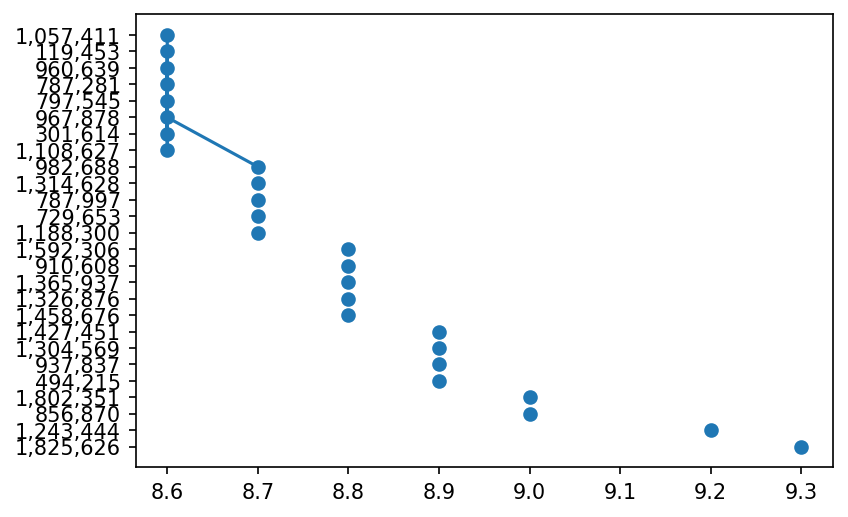

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

p_front = pare_to_frontier(ratingList, imdbVotesList, maxX = False, maxY = True)
plt.scatter(ratingList, imdbVotesList)
plt.plot(p_front[0], p_front[1])

In [12]:
## we can see more than 26 movies have rating of around 8.5 Genrally people watch this kind of rating movies


<AxesSubplot:xlabel='Runtime'>

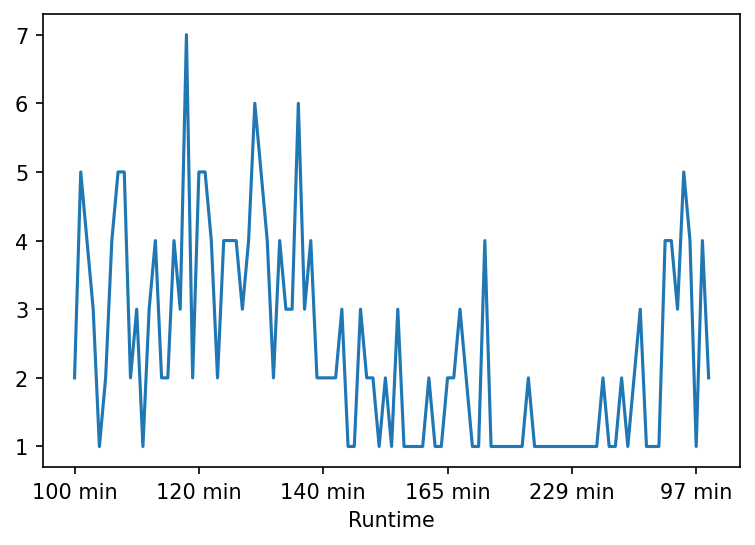

In [13]:
durationData = df
data_groupby_duration = durationData.groupby(['Runtime'])['Title'].count()
data_groupby_duration.plot()

In [14]:
runtimecount=durationData['Runtime']

timeCount=[]
for i in runtimecount:
    size = len(i)
    mod_string = i[:size - 3]
    count=int(mod_string)
    if count >= 150:
        timeCount.append(mod_string)
        
#print(timeCount)
length=len(timeCount)
print(length, ' movies have time duration more than equal to 2.5 hr.')
        

46  movies have time duration more than equal to 2.5 hr.


In [15]:
df['Language'].unique()

array(['English', 'English, Italian, Latin',
       'English, Italian, Spanish, Latin, Sicilian', 'English, Mandarin',
       'English, Hebrew, German, Polish',
       'English, Quenya, Old English, Sindarin',
       'English, Spanish, French', 'English, Sindarin',
       'English, Japanese, French', 'English, Sindarin, Old English',
       'English, Italian', 'English, Hungarian, Spanish, French',
       'English, Italian, French', 'English, French, German, Czech',
       'English, French, German, Italian', 'English, French',
       'English, German, Hebrew, Spanish, Arabic, Nepali',
       'English, German, Russian', 'English, Cantonese',
       'English, Spanish', 'English, Swahili, Xhosa, Zulu',
       'English, French, Vietnamese', 'English, Esperanto',
       'English, Russian', 'English, German, Latin',
       'English, German, French, Italian', 'English, German',
       'English, Arabic', 'English, French, Latin, Scottish Gaelic',
       'English, Arabic, Turkish', 'English, It

In [16]:
# keep only these 5 useful columns, 250 rows with no NaN field
df = df[['Title','Director','Actors','Plot','Genre']]
df

df2 = df2[['Title','Director','Actors','Plot','Genre']]

In [17]:
df.loc[(df.Genre == 'Drama')]
df2.loc[(df2.Genre == 'Drama')]

,Title,Director,Actors,Plot,Genre
8,Fight Club,David Fincher,"Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier","An insomniac office worker, looking for a way ...",Drama
14,One Flew Over the Cuckoo's Nest,Milos Forman,"Michael Berryman, Peter Brocco, Dean R. Brooks...",A criminal pleads insanity after getting into ...,Drama
63,Requiem for a Dream,Darren Aronofsky,"Ellen Burstyn, Jared Leto, Jennifer Connelly, ...",The drug-induced utopias of four Coney Island ...,Drama
81,All About Eve,Joseph L. Mankiewicz,"Bette Davis, Anne Baxter, George Sanders, Cele...",An ingenue insinuates herself into the company...,Drama
85,Good Will Hunting,Gus Van Sant,"Matt Damon, Ben Affleck, Stellan Skarsgård, Jo...","Will Hunting, a janitor at M.I.T., has a gift ...",Drama
105,Room,Lenny Abrahamson,"Brie Larson, Jacob Tremblay, Sean Bridgers, We...",A young boy is raised within the confines of a...,Drama
121,Trainspotting,Danny Boyle,"Ewan McGregor, Ewen Bremner, Jonny Lee Miller,...","Renton, deeply immersed in the Edinburgh drug ...",Drama
124,Gran Torino,Clint Eastwood,"Clint Eastwood, Christopher Carley, Bee Vang, ...",Disgruntled Korean War veteran Walt Kowalski s...,Drama
139,Network,Sidney Lumet,"Faye Dunaway, William Holden, Peter Finch, Rob...",A television network cynically exploits a dera...,Drama
170,"Paris, Texas",Wim Wenders,"Harry Dean Stanton, Sam Berry, Bernhard Wicki,...","Travis Henderson, an aimless drifter who has b...",Drama


In [18]:
# top genres (from 110 unique genres)
df['Genre'].value_counts()

Drama                           19
Crime, Drama                    14
Drama, War                       9
Animation, Adventure, Comedy     8
Crime, Drama, Thriller           8
                                ..
Action, Adventure, Mystery       1
Drama, Romance, Sci-Fi           1
Crime, Thriller                  1
Action, Crime, Thriller          1
Film-Noir, Mystery, Thriller     1
Name: Genre, Length: 110, dtype: int64

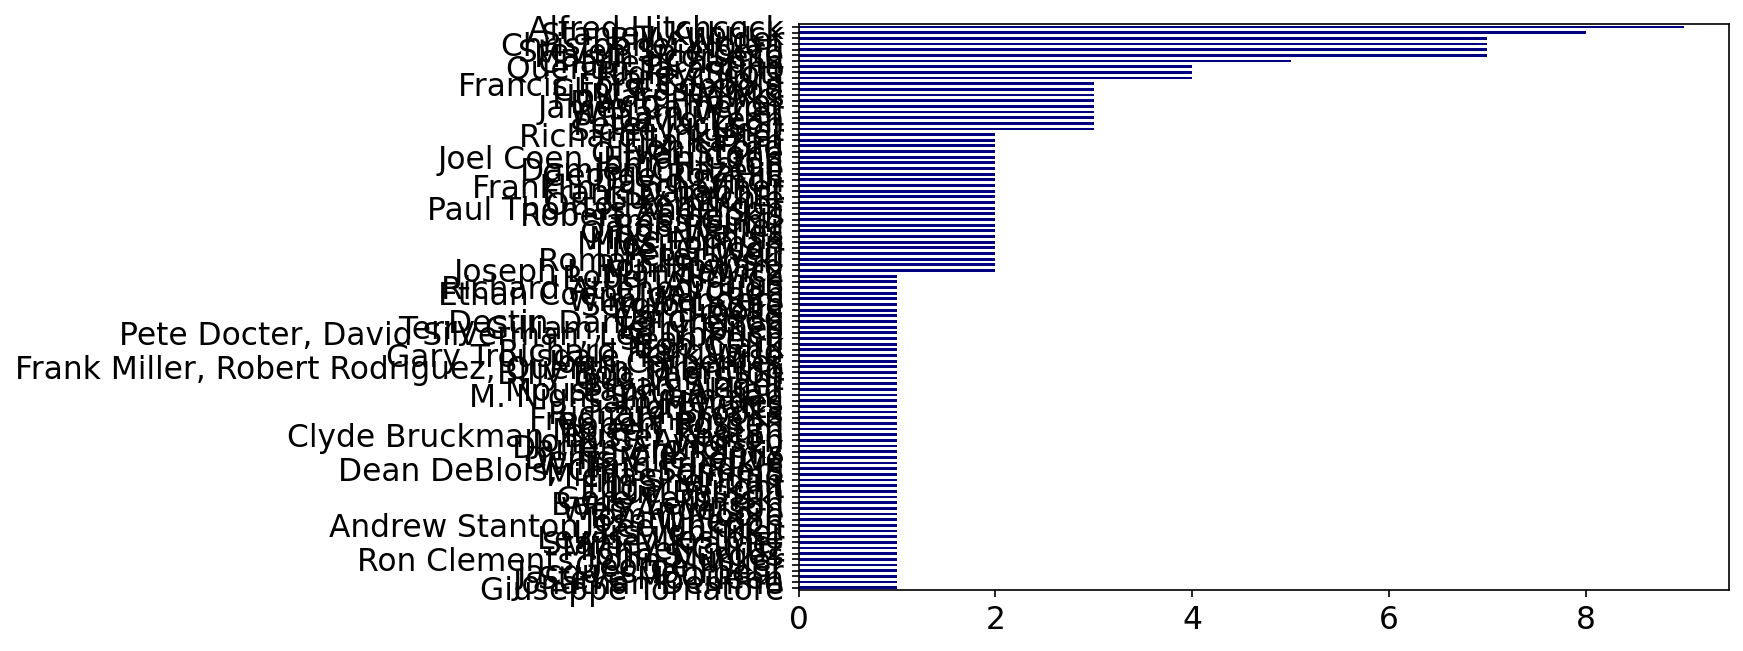

In [19]:
# 100 popular directors (from 155 unique directors)
df['Director'].value_counts()[0:100].plot(kind='barh', figsize=[8,5], fontsize=15, color='navy').invert_yaxis()

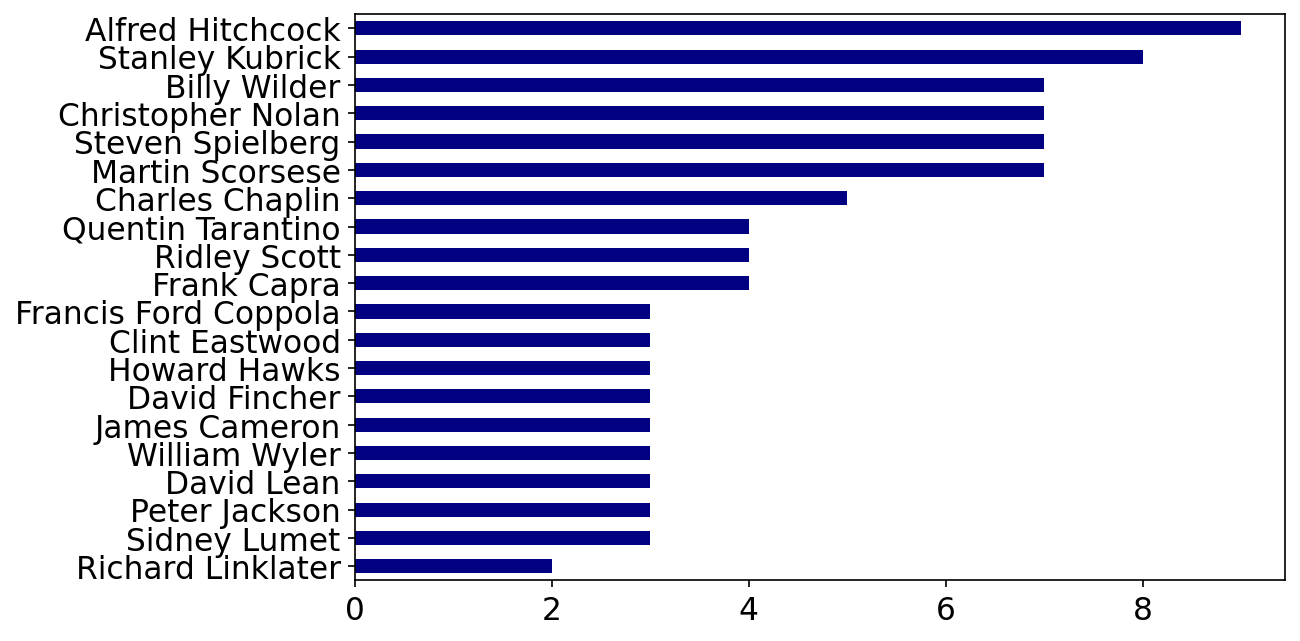

In [20]:
# 20 popular directors (from 155 unique directors)
df['Director'].value_counts()[0:20].plot(kind='barh', figsize=[8,5], fontsize=15, color='navy').invert_yaxis()

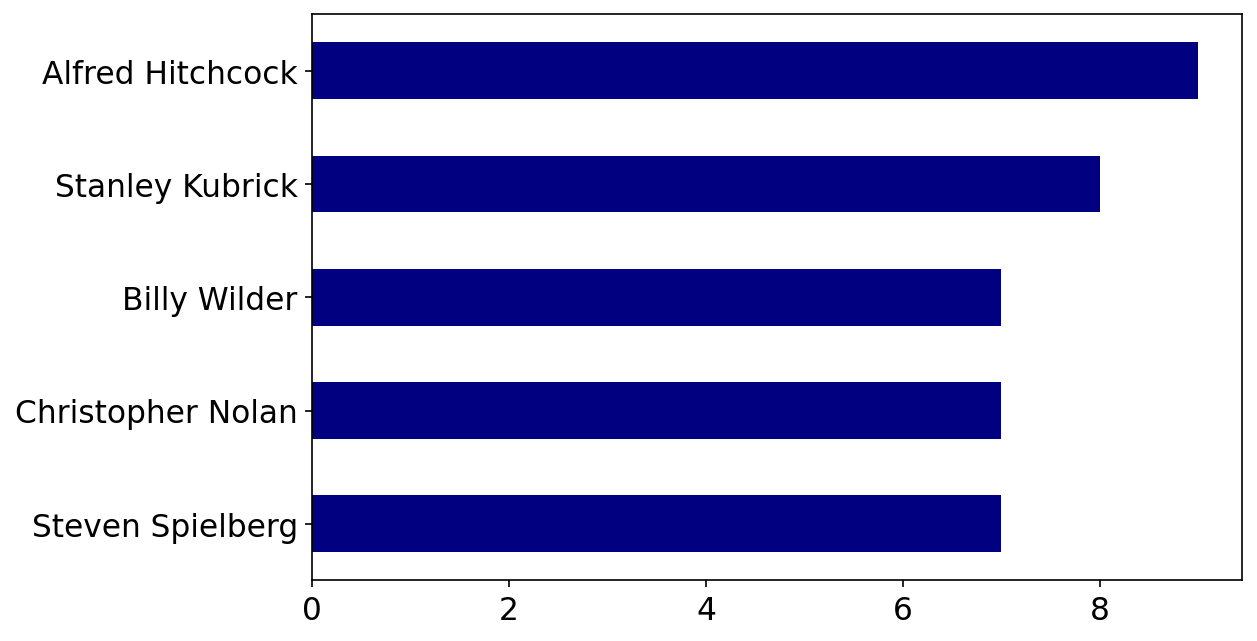

In [21]:
# 5 popular directors (from 155 unique directors)
df['Director'].value_counts()[0:5].plot(kind='barh', figsize=[8,5], fontsize=15, color='navy').invert_yaxis()

## Step 2: data pre-processing

Firstly the data has to be pre-processed using NLP to obtain only one column that contains all the attributes (in words) of each movie. After that, this information is converted into numbers by vectorization, where scores are assigned to each word. Subsequently cosine similarities can be calculated.

### To remove stop words, punctuation, white space, and convert all words to lower case
Used the Rake function to extract the most relevant words from whole sentences in the Plot column. In order to do this, applied this function to each row under the Plot column and assigned the list of key words to a new column 'Key_words'.

In [22]:
# to remove punctuations from Plot in two dfs, to make sure they are same
df['Plot'] = df['Plot'].str.replace('[^\w\s]','')
df2['Plot'] = df2['Plot'].str.replace('[^\w\s]','')

In [23]:
# to extract key words from Plot to a list in two dfs, to make sure they are same
df['Key_words'] = ''   # initializing a new column
r = Rake()   # use Rake to discard stop words (based on english stopwords from NLTK)

for index, row in df.iterrows():
    r.extract_keywords_from_text(row['Plot'])   # to extract key words from Plot, default in lower case
    key_words_dict_scores = r.get_word_degrees()    # to get dictionary with key words and their scores
    row['Key_words'] = list(key_words_dict_scores.keys())   # to assign list of key words to new column

df

# to extract key words from Plot to a list in two dfs, to make sure they are same
df2['Key_words'] = '' 
new_r = Rake()

for index, row in df2.iterrows():
    new_r.extract_keywords_from_text(row['Plot']) 
    key_words_dict_scores = new_r.get_word_degrees() 
    row['Key_words'] = list(key_words_dict_scores.keys())  

In [24]:
# to see last item in Plot in two dfs, to make sure they are same
df['Plot'][249]

'A Mumbai teen reflects on his upbringing in the slums when he is accused of cheating on the Indian Version of Who Wants to be a Millionaire'

In [25]:
df2['Plot'][249]

'A Mumbai teen reflects on his upbringing in the slums when he is accused of cheating on the Indian Version of Who Wants to be a Millionaire'

In [26]:
df['Plot'][0]

'Two imprisoned men bond over a number of years finding solace and eventual redemption through acts of common decency'

In [27]:
df2['Plot'][0]

'Two imprisoned men bond over a number of years finding solace and eventual redemption through acts of common decency'

In [28]:
# to see last dictionary extracted from Plot
key_words_dict_scores

defaultdict(<function rake_nltk.rake.Rake._build_word_co_occurance_graph.<locals>.<lambda>()>,
            {'mumbai': 3,
             'teen': 3,
             'reflects': 3,
             'slums': 1,
             'wants': 1,
             'accused': 1,
             'indian': 2,
             'version': 2,
             'upbringing': 1,
             'cheating': 1,
             'millionaire': 1})

In [29]:
# to see last item in Key_words in two dfs, to make sure they are same
df['Key_words'][249]

['mumbai',
 'teen',
 'reflects',
 'slums',
 'wants',
 'accused',
 'indian',
 'version',
 'upbringing',
 'cheating',
 'millionaire']

In [30]:
df2['Key_words'][249]

['mumbai',
 'teen',
 'reflects',
 'slums',
 'wants',
 'accused',
 'indian',
 'version',
 'upbringing',
 'cheating',
 'millionaire']

The names of actors and directors are transformed into unique identity values. This is done by merging all first and last names into one word, so that Chris Evans and Chris Hemsworth will appear different. The recommender should detect a similarity only if the person associated to different movies is exactly the same. Every word needs to be converted to lowercase to avoid duplications.

In [31]:
# to extract all genre into a list, only the first three actors into a list, and all directors into a list
df['Genre'] = df['Genre'].map(lambda x: x.split(','))
df['Actors'] = df['Actors'].map(lambda x: x.split(',')[:3])
df['Director'] = df['Director'].map(lambda x: x.split(','))

# create unique identity names by merging first & last name into one word, convert to lowercase 
for index, row in df.iterrows():
    row['Genre'] = [x.lower().replace(' ','') for x in row['Genre']]
    row['Actors'] = [x.lower().replace(' ','') for x in row['Actors']]
    row['Director'] = [x.lower().replace(' ','') for x in row['Director']]
df

# to extract all genre into a list, only the first three actors into a list, and all directors into a list
df2['Genre'] = df2['Genre'].map(lambda x: x.split(','))
df2['Actors'] = df2['Actors'].map(lambda x: x.split(',')[:3])
df2['Director'] = df2['Director'].map(lambda x: x.split(','))

# create unique identity names by merging first & last name into one word, convert to lowercase 
for index, row in df2.iterrows():
    row['Genre'] = [x.lower().replace(' ','') for x in row['Genre']]
    row['Actors'] = [x.lower().replace(' ','') for x in row['Actors']]
    row['Director'] = [x.lower().replace(' ','') for x in row['Director']]
df2

,Title,Director,Actors,Plot,Genre,Key_words
0,The Shawshank Redemption,[frankdarabont],"[timrobbins, morganfreeman, bobgunton]",Two imprisoned men bond over a number of years...,"[crime, drama]","[acts, years, finding, solace, two, imprisoned..."
1,The Godfather,[francisfordcoppola],"[marlonbrando, alpacino, jamescaan]",The aging patriarch of an organized crime dyna...,"[crime, drama]","[reluctant, son, aging, patriarch, organized, ..."
2,The Godfather: Part II,[francisfordcoppola],"[alpacino, robertduvall, dianekeaton]",The early life and career of Vito Corleone in ...,"[crime, drama]","[vito, corleone, family, crime, syndicate, ear..."
3,The Dark Knight,[christophernolan],"[christianbale, heathledger, aaroneckhart]",When the menace known as the Joker emerges fro...,"[action, crime, drama]","[wreaks, havoc, greatest, psychological, abili..."
4,12 Angry Men,[sidneylumet],"[martinbalsam, johnfiedler, leej.cobb]",A jury holdout attempts to prevent a miscarria...,"[crime, drama]","[evidence, jury, holdout, attempts, forcing, c..."
...,...,...,...,...,...,...
245,The Lost Weekend,[billywilder],"[raymilland, janewyman, phillipterry]",The desperate life of a chronic alcoholic is f...,"[drama, film-noir]","[desperate, life, chronic, alcoholic, followed..."
246,Short Term 12,[destindanielcretton],"[brielarson, johngallagherjr., stephaniebeatriz]",A 20something supervising staff member of a re...,[drama],"[coworker, 20something, supervising, staff, me..."
247,His Girl Friday,[howardhawks],"[carygrant, rosalindrussell, ralphbellamy]",A newspaper editor uses every trick in the boo...,"[comedy, drama, romance]","[newspaper, editor, uses, every, trick, remarr..."
248,The Straight Story,[davidlynch],"[sissyspacek, janegallowayheitz, josepha.carpe...",An old man makes a long journey by lawnmover t...,"[biography, drama]","[relationship, lawnmover, tractor, mend, long,..."


## Step 3: create word representation by combining column attributes to Main_Info

In [32]:
# to combine 3 lists (3 columns) of key words into 1 sentence under Bag_of_words column
df['Main_info'] = ''
columns = ['Genre', 'Director', 'Actors']

for index, row in df.iterrows():
    words = ''
    for col in columns:
        words += ' '.join(row[col]) + ' '
    row['Main_info'] = words
    
# strip white spaces infront and behind, replace multiple whitespaces (if any)
df['Main_info'] = df['Main_info'].str.strip().str.replace('   ', ' ').str.replace('  ', ' ')

df = df[['Title','Main_info']]
df

,Title,Main_info
0,The Shawshank Redemption,crime drama frankdarabont timrobbins morganfre...
1,The Godfather,crime drama francisfordcoppola marlonbrando al...
2,The Godfather: Part II,crime drama francisfordcoppola alpacino robert...
3,The Dark Knight,action crime drama christophernolan christianb...
4,12 Angry Men,crime drama sidneylumet martinbalsam johnfiedl...
...,...,...
245,The Lost Weekend,drama film-noir billywilder raymilland janewym...
246,Short Term 12,drama destindanielcretton brielarson johngalla...
247,His Girl Friday,comedy drama romance howardhawks carygrant ros...
248,The Straight Story,biography drama davidlynch sissyspacek janegal...


In [33]:
# an example to see what is in the Main_info
df['Main_info'][0]

'crime drama frankdarabont timrobbins morganfreeman bobgunton'

In [34]:
# to generate the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['Main_info'])
count_matrix

<250x765 sparse matrix of type '<class 'numpy.int64'>'
	with 1715 stored elements in Compressed Sparse Row format>

### Similarity Matrix 1

In [35]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.33333333 0.33333333 ... 0.15430335 0.15430335 0.16666667]
 [0.33333333 1.         0.66666667 ... 0.15430335 0.15430335 0.16666667]
 [0.33333333 0.66666667 1.         ... 0.15430335 0.15430335 0.16666667]
 ...
 [0.15430335 0.15430335 0.15430335 ... 1.         0.14285714 0.15430335]
 [0.15430335 0.15430335 0.15430335 ... 0.14285714 1.         0.15430335]
 [0.16666667 0.16666667 0.16666667 ... 0.15430335 0.15430335 1.        ]]


## Step 4: create word representation by combining column attributes to New_Plot

In [36]:
df2['New_Plot'] = ''
columns = ['Key_words']

for index, row in df2.iterrows():
    words = ''
    for col in columns:
        words += ' '.join(row[col]) + ' '
    row['New_Plot'] = words
    
df2['New_Plot'] = df2['New_Plot'].str.strip().str.replace('   ', ' ').str.replace('  ', ' ')

df2 = df2[['Title','New_Plot']]
df2

,Title,New_Plot
0,The Shawshank Redemption,acts years finding solace two imprisoned men b...
1,The Godfather,reluctant son aging patriarch organized crime ...
2,The Godfather: Part II,vito corleone family crime syndicate early lif...
3,The Dark Knight,wreaks havoc greatest psychological ability my...
4,12 Angry Men,evidence jury holdout attempts forcing colleag...
...,...,...
245,The Lost Weekend,desperate life chronic alcoholic followed four...
246,Short Term 12,coworker 20something supervising staff member ...
247,His Girl Friday,newspaper editor uses every trick remarrying a...
248,The Straight Story,relationship lawnmover tractor mend long journ...


In [37]:
# an example to see what is in the New_Plot
df2['New_Plot'][0]

'acts years finding solace two imprisoned men bond common decency number eventual redemption'

In [38]:
# to generate the count matrix
new_count = CountVectorizer()
new_count_matrix = new_count.fit_transform(df2['New_Plot'])
new_count_matrix

<250x2254 sparse matrix of type '<class 'numpy.int64'>'
	with 3604 stored elements in Compressed Sparse Row format>

### Similarity Matrix 2

In [39]:
cosine_sim2 = cosine_similarity(new_count_matrix, new_count_matrix)
print(cosine_sim2)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.14625448 ... 0.         0.         0.        ]
 [0.         0.14625448 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


### Then we need to create vector representation for Main_info & plot and the similarity matrix

The recommender model can only read and compare a vector (matrix) with another, so we need to convert the 'Main_info' into vector representation using CountVectorizer, which is a simple frequency counter for each word in the Main_info column. Once I have the matrix containing the count for each word, I can apply the cosine_similarity function to compare similarities between movies.

Next is to create a Series of movie titles, so that the series index can match the row/column index of the similarity matrix

In [40]:
# to create a Series for movie titles which can be used as indices (each index is mapped to a movie title)
indices = pd.Series(df['Title'])
indices2 = pd.Series(df2['Title'])
indices[:10]

0                             The Shawshank Redemption
1                                        The Godfather
2                               The Godfather: Part II
3                                      The Dark Knight
4                                         12 Angry Men
5                                     Schindler's List
6        The Lord of the Rings: The Return of the King
7                                         Pulp Fiction
8                                           Fight Club
9    The Lord of the Rings: The Fellowship of the Ring
Name: Title, dtype: object

In [41]:
indices2[:8]  # make sure they are same

0                         The Shawshank Redemption
1                                    The Godfather
2                           The Godfather: Part II
3                                  The Dark Knight
4                                     12 Angry Men
5                                 Schindler's List
6    The Lord of the Rings: The Return of the King
7                                     Pulp Fiction
Name: Title, dtype: object

## Step 5: run and test the recommender model
The final step is to create a function that takes in a movie title as input, and returns the top 10 similar movies. This function will match the input movie title with the corresponding index of the Similarity Matrix, and extract the row of similarity values in descending order. The top 10 similar movies can be found by extracting the top 11 values and subsequently discarding the first index (which is the input movie itself)

By comparing the eigenvalues of two similar matrices, we can get different or similar results. This not only proves the relevance and similarity of Main_Info and New_Polt, but also proves the stability of the algorithm.

But because the results will still be different, consider combining two similarity matrices for recommendation. We will compare the results obtained by relying on the two matrices, take the same movie as the "most recommended movie", and then use the remaining results as the "general recommendation". This results in higher reliability.

In [42]:
# these functions take in a movie title as input and returns the top 10 recommended (similar) movies
import random

def extra_same_elem(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    iset = set1.intersection(set2)
    return list(iset)


def recommend_from_1(title, cosine_sim = cosine_sim):
    recommended_movies = []
    idx = indices[indices == title].index[0]   # to get the index of the movie title matching the input movie
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)   # similarity scores in descending order
    top_10_indices = list(score_series.iloc[1:11].index)   # to get the indices of top 10 most similar movies
    
    for i in top_10_indices:  
        recommended_movies.append(list(df['Title'])[i])
        
    return recommended_movies

def recommend_from_2(title, cosine_sim2 = cosine_sim2):
    recommended_movies = []
    idx = indices[indices == title].index[0]
    score_series = pd.Series(cosine_sim2[idx]).sort_values(ascending = False)
    top_10_indices = list(score_series.iloc[1:11].index)
    # [1:11] to exclude 0 (index 0 is the input movie itself)
    
    for i in top_10_indices: # to append the titles of top 10 similar movies to the recommended_movies list
        recommended_movies.append(list(df['Title'])[i])
        
    return recommended_movies

def recommend_from_combine(title, cosine_sim = cosine_sim, cosine_sim2 = cosine_sim2):
    final_recommended_movies = []
    recommended_movies1 = []
    idx = indices[indices == title].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_10_indices = list(score_series.iloc[1:11].index)
    
    for i in top_10_indices:
        recommended_movies1.append(list(df['Title'])[i])
        
    recommended_movies2 = []
    idx2 = indices2[indices2 == title].index[0]
    score_series2 = pd.Series(cosine_sim2[idx2]).sort_values(ascending = False)
    top_10_indices2 = list(score_series2.iloc[1:11].index)
    
    for i in top_10_indices2:
        recommended_movies2.append(list(df2['Title'])[i])
        
    find_same = extra_same_elem(recommended_movies1, recommended_movies2)
    
    if len(find_same) != 0:
        print("The most recommend moives are: \n")
        print(find_same)
        
        same_len = len(find_same)
        for j in range(same_len):
            final_recommended_movies.append(find_same[j])
        for xxx in range(len(recommended_movies1)):
            final_recommended_movies.append(recommended_movies1[xxx])
        for xxx in range(len(recommended_movies1)):
            final_recommended_movies.append(recommended_movies2[xxx])
            
        final_recommended_movies = list(set(final_recommended_movies))
            
    else:
        print("There is no most recommend moive!\n")
        if random.randint(0,9)%2 == 0:
            final_recommended_movies = recommended_movies1.copy()
        else:
            final_recommended_movies = recommended_movies2.copy()
            
    return final_recommended_movies

In [43]:
recommend_from_1('The Avengers')

['Spider-Man: Homecoming',
 'The Terminator',
 'Mad Max: Fury Road',
 'Aliens',
 'Guardians of the Galaxy',
 'Guardians of the Galaxy Vol. 2',
 'Terminator 2: Judgment Day',
 'Logan',
 'Inception',
 'The Matrix']

In [44]:
recommend_from_2('The Avengers')

['Guardians of the Galaxy Vol. 2',
 'Aliens',
 'Guardians of the Galaxy',
 'Kill Bill: Vol. 1',
 'The Martian',
 'Zootopia',
 'The Thing',
 'Indiana Jones and the Last Crusade',
 'The Dark Knight',
 'Witness for the Prosecution']

In [45]:
recommend_from_combine('The Avengers')

The most recommend moives are: 

['Guardians of the Galaxy Vol. 2', 'Guardians of the Galaxy', 'Aliens']


['The Thing',
 'The Terminator',
 'Mad Max: Fury Road',
 'Witness for the Prosecution',
 'The Dark Knight',
 'Guardians of the Galaxy',
 'Aliens',
 'Zootopia',
 'Spider-Man: Homecoming',
 'Inception',
 'The Martian',
 'Logan',
 'Indiana Jones and the Last Crusade',
 'The Matrix',
 'Guardians of the Galaxy Vol. 2',
 'Terminator 2: Judgment Day',
 'Kill Bill: Vol. 1']

In [46]:
recommend_from_combine('Léon: The Professional')

There is no most recommend moive!



['Gladiator',
 'Arsenic and Old Lace',
 'How to Train Your Dragon',
 'The Kid',
 'Million Dollar Baby',
 'The Manchurian Candidate',
 'It Happened One Night',
 'The Matrix',
 'The Straight Story',
 'Rear Window']

In [47]:
recommend_from_combine('Léon: The Professional')

There is no most recommend moive!



['Reservoir Dogs',
 'The Departed',
 'Rope',
 'V for Vendetta',
 'The Silence of the Lambs',
 'No Country for Old Men',
 'On the Waterfront',
 'Fargo',
 'Casino',
 'Dogville']